2020 anomalous year in PC?
average season

In [2]:
import numpy as np
import xarray as xr
import pandas as pd
import xeofs as xe
import pandas as pd
import numpy as np

import stats_mca_gemini as smg


import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from cartopy.crs import Orthographic, PlateCarree, Robinson
from cartopy.feature import LAND
from matplotlib.gridspec import GridSpec

from scipy import signal

In [3]:
def standardize(x):
    return (x - x.mean(dim='time')).std('time')

In [4]:
path = "../../data0/yvu/ERA5/"
file = "era5_singlelvl_monthly_temperature.nc"

ds = xr.open_dataset(path+file)
ds = ds.rename({"valid_time":"time"})
ds['t2m'] = ds.t2m * ds.lsm # apply land-sea mask

lat = ds.latitude
lon = ds.longitude

weights = np.cos(np.deg2rad(ds.latitude))
weights.name = "weights"

# Left: North Atlantic, Right: Siberia
## MCA, months 1-3 JFM

In [5]:
# Apply MCA over months 1-3 JFM
# remove linear trend and fill nan
ds_t2m = smg.preprocess_for_mca(ds, var='t2m', month_start=1, month_end=3, region=smg.siberia)
ds_sst = smg.preprocess_for_mca(ds, var='sst', month_start=1, month_end=3, region=smg.north_atlantic)

# scf, singular_vectors, scores, hom_pats, pvals_hom, het_pats, pvals_het = smg.stats_mca(ds_sst, ds_t2m, n_modes=3)

Slicing data for the 'Siberia' region.
Filtering for months: 1 through 3.
Calculating linear trend (this handles NaNs automatically)...
Finished preprocessing 't2m' for MCA.
Slicing data for the 'North Atlantic' region.
Filtering for months: 1 through 3.
Calculating linear trend (this handles NaNs automatically)...
Finished preprocessing 'sst' for MCA.


In [6]:
mca = xe.cross.MCA(n_modes=12, standardize=False, use_coslat=True)
mca.fit(ds_sst, ds_t2m, dim="time")
mca.squared_covariance_fraction()

singular_vectors = mca.components()
scores = mca.scores()

hom_pats, pvals_hom = mca.homogeneous_patterns()
het_pats, pvals_het = mca.heterogeneous_patterns()

hom_mask = [values < 0.05 for values in pvals_hom]
het_mask = [values < 0.05 for values in pvals_het]

/home/yvu/.conda/envs/2020siberia/lib/python3.11/site-packages/xeofs/linalg/_numpy/_svd.py:233: UserWarning: Dataset has 77 components, explaining 92.62% of the variance. However, 99.90% explained variance was requested. Please consider increasing `init_rank_reduction`.
  warnings.warn(
/home/yvu/.conda/envs/2020siberia/lib/python3.11/site-packages/xeofs/linalg/_numpy/_svd.py:233: UserWarning: Dataset has 77 components, explaining 99.76% of the variance. However, 99.90% explained variance was requested. Please consider increasing `init_rank_reduction`.
  warnings.warn(
/home/yvu/.conda/envs/2020siberia/lib/python3.11/site-packages/xeofs/utils/optional/statistics.py:53: RuntimeWarning: invalid value encountered in divide
  X = X / X.std(0)
/home/yvu/.conda/envs/2020siberia/lib/python3.11/site-packages/xeofs/utils/optional/statistics.py:53: RuntimeWarning: invalid value encountered in divide
  X = X / X.std(0)


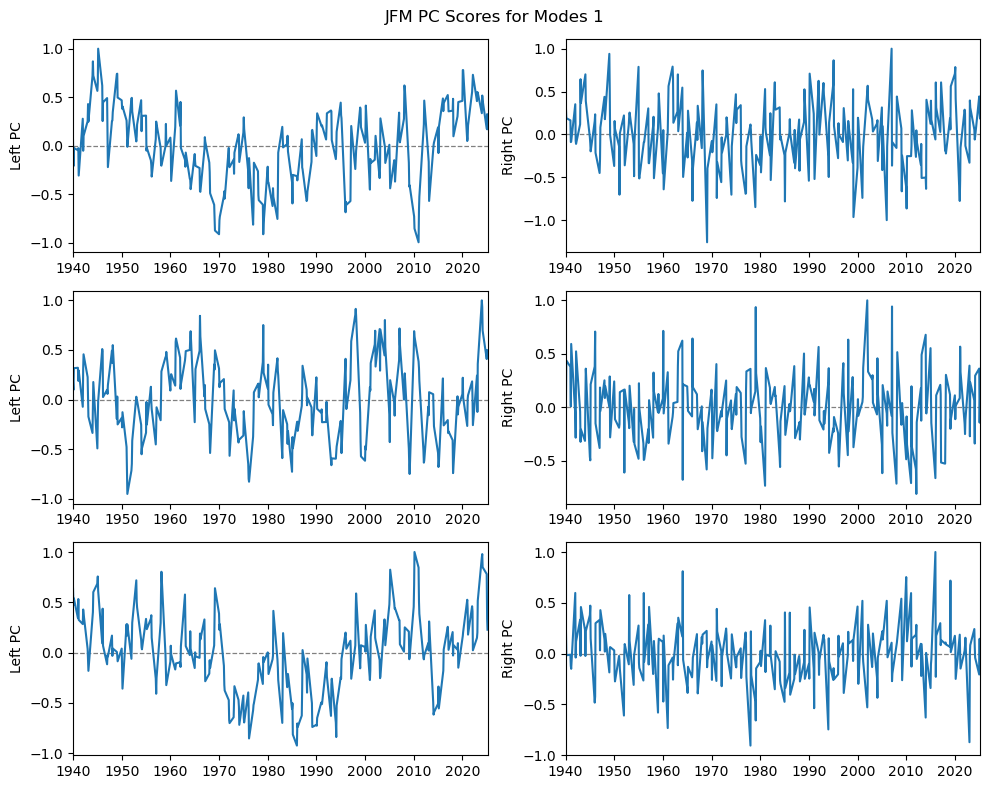

In [7]:
## Plotting
fig, ax = plt.subplots(3,2,figsize=(10, 8))

for i in range(3):
    ax[i,0].axhline(y=0, color='grey', linestyle='--',linewidth=0.9)
    ax[i,1].axhline(y=0, color='grey', linestyle='--',linewidth=0.9)
    
    normalized_pc1=scores[0].sel(mode=i+1)/scores[0].sel(mode=i+1).max()
    normalized_pc2=scores[1].sel(mode=i+1)/scores[1].sel(mode=i+1).max()
    ax[i,0].plot(scores[0].sel(mode=i+1).time,normalized_pc1)
    ax[i,1].plot(scores[1].sel(mode=i+1).time,normalized_pc2)
    
    # scores[0].sel(mode=i+1).plot(ax=ax[i,0])
    # scores[1].sel(mode=i+1).plot(ax=ax[i,1])
    ax[i,0].set_xlim(scores[0].time.min(),scores[0].time.max())
    ax[i,1].set_xlim(scores[0].time.min(),scores[0].time.max())
    years = mdates.YearLocator(10)  # Every 10 years
    ax[i,0].xaxis.set_major_locator(years)
    ax[i,1].xaxis.set_major_locator(years)
    ax[i,0].set_xlabel("")
    ax[i,1].set_xlabel("")
    ax[i,0].set_ylabel("Left PC")
    ax[i,1].set_ylabel("Right PC")
    # ax[i,0].set_title("")
    # ax[i,1].set_title("")
plt.suptitle("JFM PC Scores for Modes 1")
plt.tight_layout()

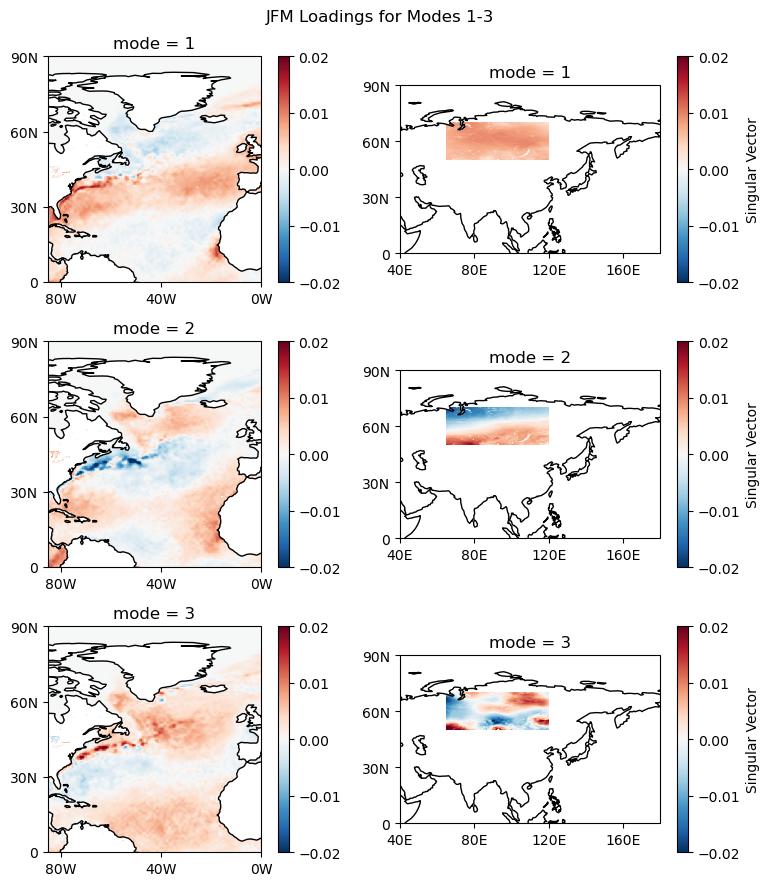

In [9]:
# Define the tick labels for x (longitude) and y (latitude)
x_tick_labels = ['40E', '80E', '120E', '160E']
y_tick_labels = ['0', '30N', '60N', '90N']
levels = np.linspace(-0.02, 0.02, 5)

kwargs1 = {'cmap':'RdBu_r','vmin':-0.02,'vmax':0.02}
kwargs2 = {'cmap':'RdBu_r','label': "Singular Vector",'vmin':-0.02,'vmax':0.02}

fig, ax = plt.subplots(3,2,figsize=(8,9), subplot_kw={'projection': PlateCarree()})
for i in range(3):
    p1 = singular_vectors[0].sel(mode=i+1).plot(ax=ax[i,0], transform=PlateCarree(), add_colorbar=False, **kwargs1)
    p2 = singular_vectors[1].sel(mode=i+1).plot(ax=ax[i,1], transform=PlateCarree(), add_colorbar=False,**kwargs2)
    
    ax[i,1].set_xlim(40,180)
    ax[i,1].set_ylim(0,90)
    
    # # Add x and y ticks for latitude and longitude
    ax[i, 0].set_xticks(np.arange(-80,40,40))
    ax[i, 0].set_yticks(range(0,120,30))
    ax[i, 1].set_xticks(range(40,180,40))
    ax[i, 1].set_yticks(range(0,120,30))
 
    ax[i, 0].set_xticklabels(['80W', '40W', '0W'])
    ax[i, 0].set_yticklabels(y_tick_labels)
    ax[i, 1].set_xticklabels(['40E', '80E', '120E', '160E'])
    ax[i, 1].set_yticklabels(y_tick_labels)
    
    ax[i,0].set_ylabel("")
    ax[i,1].set_ylabel("")
    ax[i,0].set_xlabel("")
    ax[i,1].set_xlabel("")
    
    p1.axes.coastlines()
    p2.axes.coastlines()
    # Ensure both plots are square
    ax[i, 0].set_aspect('equal', adjustable='box')
    ax[i, 1].set_aspect('equal', adjustable='box')

    cbar1 = fig.colorbar(p1, ax=ax[i, 0], orientation='vertical', ticks=levels)
    cbar2 = fig.colorbar(p2, ax=ax[i, 1], orientation='vertical', ticks=levels)
    
    # Set colorbar labels
    cbar2.set_label('Singular Vector')
plt.suptitle("JFM Loadings for Modes 1-3")
plt.tight_layout()